In [47]:
# import nbimporter
import numpy as np
import pandas as pd
import yfinance as yf
from hmmlearn.hmm import GaussianHMM
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt


In [48]:
def get_stock_data(ticker, start, end):
    data = yf.download(ticker, start=start, end=end)
            
    return data[['Close', 'High', 'Low', 'Open', 'Volume']]

def get_key_features(data):
    df = pd.DataFrame()
    
    df['Close'] = data['Close']
    df['High'] = data['High']
    df['Low'] = data['Low']
    df['Open'] = data['Open']
    df['Volume'] = data['Volume']
    
    # Moving Averages
    df['MA50'] = data['Close'].rolling(window=50).mean()
    df['MA200'] = data['Close'].rolling(window=200).mean()

    # RSI
    delta = data['Close'].diff()
    # use ema instead of sma
    # gain = (delta.where(delta > 0, 0)).rolling(14).mean()
    # loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
    # df['RSI'] = 100 - (100 / (1 + gain / loss))
    gain = (delta.where(delta > 0, 0)).ewm(span=14).mean()
    loss = (-delta.where(delta < 0, 0)).ewm(span=14).mean()
    rs = gain / loss
    df['RSI'] = 100 - (100 / (1 + rs))
    

    # Volatility
    df['Volatility'] = data['Close'].rolling(20).std() / data['Close']
    df['Daily_Return'] = data['Close'].pct_change()
    df['Price_Momentum'] = data['Close'].pct_change(periods=10)

    # Volume
    df['Volume_MA20'] = df['Volume'].ewm(span=20).mean()  
    df['Volume_Ratio'] = df['Volume'] / df['Volume_MA20']

    # MACD
    exp1 = data['Close'].ewm(span=12, adjust=False).mean()
    exp2 = data['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = exp1 - exp2
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    # ATR
    high_low = data['High'] - data['Low']
    high_close = np.abs(data['High'] - data['Close'].shift())
    low_close = np.abs(data['Low'] - data['Close'].shift())
    # use ema instead of sma
    # ranges = pd.concat([high_low, high_close, low_close], axis=1)
    # df['ATR'] = ranges.max(axis=1).rolling(14).mean()
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['ATR'] = tr.ewm(span=14, adjust=False).mean()
    
    
    df = handle_missing_values(df)
    
    return df

# add new method to handle missing values
def handle_missing_values(df):

    price_cols = ['Close', 'High', 'Low', 'Open']
    indicator_cols = ['RSI', 'MACD', 'Signal_Line']
    
    # use forward fill for price data
    df[price_cols] = df[price_cols].fillna(method='ffill')
    
    # fill missing values in indicator columns with 0
    df[indicator_cols] = df[indicator_cols].fillna(0)
    
    # replace inf and -inf with NaN
    df = df.replace([np.inf, -np.inf], np.nan)
    # fill NaN with mean
    df = df.fillna(df.mean())
    
    return df


In [49]:
def define_market_states(data, bull_threshold=0.1, bear_threshold=-0.1):
    """
    Define market states: Bear Market (0), Sideways/Consolidation (1), Bull Market (2)
    """
    data['MA200'] = data['Close'].rolling(window=200).mean()
    data['Trend'] = data['Close'].diff()

    # Initialize all states as sideways/consolidation (1)
    states = np.ones(len(data))

    bull_condition = (data['Close'] > data['MA200']) & (data['Trend'] > bull_threshold)
    bear_condition = (data['Close'] < data['MA200']) & (data['Trend'] < bear_threshold)

    states[bull_condition] = 2  # Set bull market periods
    states[bear_condition] = 0  # Set bear market periods

    return states.astype(int)

def create_transition_matrix_from_states(states, n_states=3):
    
    transmat = np.zeros((n_states, n_states))
    for (current, next_) in zip(states[:-1], states[1:]):
        transmat[current, next_] += 1
    transmat = transmat / transmat.sum(axis=1, keepdims=True)
    return transmat


In [50]:
def train_hmm_with_states(features, n_states=3, transmat=None, random_seed=42):

    try:
        model = GaussianHMM(n_components=3, covariance_type="diag", n_iter=1000, random_state=random_seed, init_params="mc")

        if transmat is not None:
            model.transmat_ = transmat

        model.fit(features)

        return model
    except Exception as e:
        raise Exception(f"Error training HMM: {e}")


In [51]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

def kfold_evaluate_model(features, transmat, n_splits=5, random_seed=42):

    if np.isnan(features).any():
        features = np.nan_to_num(features, nan=0.0)
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_seed)
    fold_scores = []
    
    for train_index, valid_index in kf.split(features):
        train_features = features[train_index]
        valid_features = features[valid_index]
        
        scaler = StandardScaler()
        train_features = scaler.fit_transform(train_features)
        valid_features = scaler.transform(valid_features)
        
        model = train_hmm_with_states(train_features, transmat=transmat, random_seed=random_seed)

        states = model.predict(train_features)
        
        valid_score = model.score(valid_features)
        fold_scores.append(valid_score)
    
    return states, np.mean(fold_scores), np.std(fold_scores)

In [52]:
ticker = "AAPL"
start_date = "2020-01-01"
end_date = "2024-01-01"
data = get_stock_data(ticker, start_date, end_date)
features_df = get_key_features(data)

[*********************100%***********************]  1 of 1 completed
/var/folders/2h/wrsf34y94g19f0r8w98wtcm40000gn/T/ipykernel_56613/1019579044.py:68: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[price_cols] = df[price_cols].fillna(method='ffill')


In [53]:
# feature_sets = [
#     ["Volume"],
#     ["RSI"],
#     ["Daily_Return", "Volatility"],
#     ["Volume_Ratio"]
# ]

# feature_sets = [
    
    # Basic Combination: Technical Indicators + Price
    # ["RSI", "MA50", "MA200", "Close"],
    
    # Price Momentum Combination
    # ["RSI", "Daily_Return", "Volatility", "Price_Momentum"],
    
    
    # Comprehensive Technical Combination
    # ["RSI", "MACD", "Signal_Line", "ATR"],
    
    # Complete Combination
#     ["RSI", "MA50", "Volume_Ratio", "Daily_Return", "ATR"]
# ]


feature_sets = [
  
    ["Close"],            
    ["MA50"],
    ["MA200"],
    ["Volatility"],
    ["Daily_Return"],
    ["Price_Momentum"],
    ["Volume"],
    ["Volume_Ratio"],                  
    ["MACD"],                   
    ["ATR"],   
    ["RSI"],    
                          
    ["RSI", "MA50"], 
                     
    ["RSI", "Volume_Ratio"],                 
    
    ["RSI", "MA50", "MA200", "Close"],  
    
    ["RSI", "MACD", "Signal_Line", "MA50"],
    
    ["RSI", "Daily_Return", "Volatility", "Price_Momentum"],
    
    ["RSI", "ATR", "Volatility", "Daily_Return"],
    
    ["RSI", "Volume_Ratio", "Volume_MA20", "Daily_Return"],
    
    ["RSI", "MA50", "Volume_Ratio", "ATR", "MACD"]
]

In [54]:
# n_states = 3

# Create a uniform transition matrix (equal probability for all transitions)
uniform_transmat = np.full((3, 3), 1.0/3.0)

# Create a persistent transition matrix (high probability to stay in the same state)
persistent_transmat = np.array([
    [0.8, 0.15, 0.05],  
    [0.1, 0.8, 0.1],
    [0.05, 0.15, 0.8],  
])

# Create a transition matrix based on observed state changes
initial_states = define_market_states(features_df)
state_based_transmat = create_transition_matrix_from_states(initial_states, n_states=3)

transmat_options = {
    "Default": None,
    "Uniform": uniform_transmat,
    "Persistent": persistent_transmat,
    "State-Based": state_based_transmat
}

In [55]:
test_size = 0.2
train_data, test_data = train_test_split(features_df, test_size=test_size, shuffle=False)

results = []

for feature_set in feature_sets:
    try:
        features = np.column_stack([features_df[feat].values for feat in feature_set])
        for transmat_name, transmat in transmat_options.items():
            try:
                states, mean_score, std_score = kfold_evaluate_model(features, transmat, n_splits=5)
                results.append({
                    "Feature_Set": feature_set,
                    "Transition": transmat_name,
                    "KFold_Mean_Score": mean_score,
                    "KFold_Std_Dev": std_score
                })
            except Exception as e:
                print(f"Error with {transmat_name}: {str(e)}")
    except Exception as e:
        print(f"Error with feature set {feature_set}: {str(e)}")


results_df = pd.DataFrame(results)
print(results_df)


                                       Feature_Set   Transition  \
0                                          [Close]      Default   
1                                          [Close]      Uniform   
2                                          [Close]   Persistent   
3                                          [Close]  State-Based   
4                                           [MA50]      Default   
..                                             ...          ...   
71  [RSI, Volume_Ratio, Volume_MA20, Daily_Return]  State-Based   
72            [RSI, MA50, Volume_Ratio, ATR, MACD]      Default   
73            [RSI, MA50, Volume_Ratio, ATR, MACD]      Uniform   
74            [RSI, MA50, Volume_Ratio, ATR, MACD]   Persistent   
75            [RSI, MA50, Volume_Ratio, ATR, MACD]  State-Based   

    KFold_Mean_Score  KFold_Std_Dev  
0        -189.909499       9.198048  
1        -116.031369       9.210178  
2        -106.980106       6.127211  
3        -113.572924       9.023992  
4    

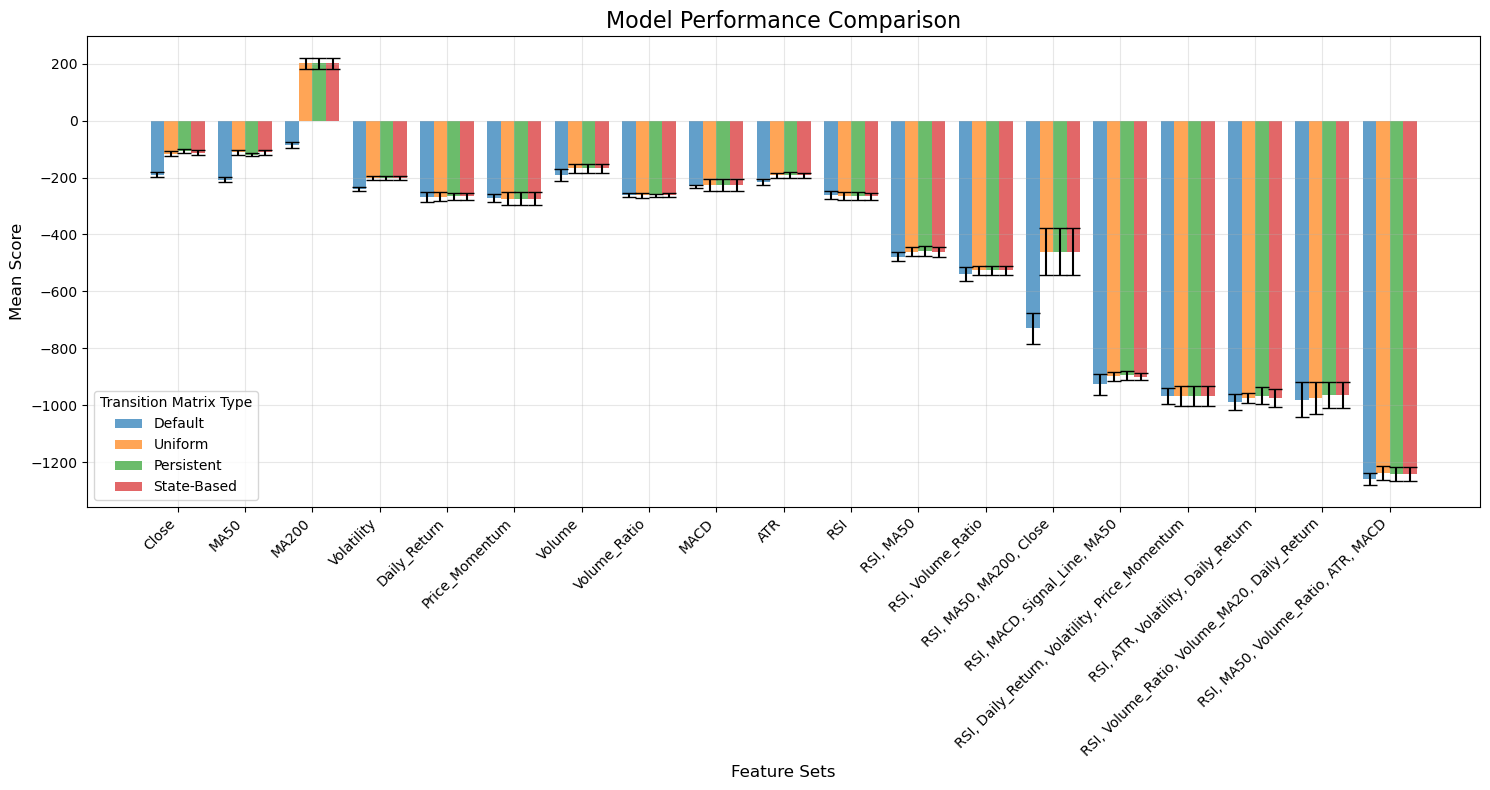

In [56]:
def plot_model_results(results_df):

    plt.figure(figsize=(15, 8))
    
    feature_sets = results_df['Feature_Set'].drop_duplicates().values
    transitions = results_df['Transition'].unique()
    
    bar_width = 0.2
    positions = np.arange(len(feature_sets))
    
    for i, transition in enumerate(transitions):

        mask = results_df['Transition'] == transition
        scores = results_df[mask]['KFold_Mean_Score']
        std_devs = results_df[mask]['KFold_Std_Dev']
        
        plt.bar(positions + i*bar_width, 
                scores,
                bar_width,
                label=transition,
                alpha=0.7)
        
        plt.errorbar(positions + i*bar_width,
                    scores,
                    yerr=std_devs,
                    fmt='none',
                    color='black',
                    capsize=5)
    
    plt.title('Model Performance Comparison', fontsize=16)
    plt.xlabel('Feature Sets', fontsize=12)
    plt.ylabel('Mean Score', fontsize=12)
    
    feature_labels = [str(fs).strip('[]').replace("'", "") for fs in feature_sets]
    plt.xticks(positions + bar_width*(len(transitions)-1)/2, 
               feature_labels, 
               rotation=45, 
               ha='right')
    

    plt.legend(title='Transition Matrix Type')
    
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    return plt.gcf()

fig = plot_model_results(results_df)
plt.show()
plt.close()

In [57]:
ma200_scores = results_df[results_df['Feature_Set'].apply(lambda x: x == ['MA200'])]
print("MA200:")
print(ma200_scores)


MA200:
   Feature_Set   Transition  KFold_Mean_Score  KFold_Std_Dev
8      [MA200]      Default        -85.227847      11.594114
9      [MA200]      Uniform        200.668200      20.323776
10     [MA200]   Persistent        200.667870      20.323063
11     [MA200]  State-Based        200.667846      20.323243


### Key Findings:

1. MA200 emerged as the strongest single feature:
- Performed best among all single features
- Got positive scores with all transition matrix types
- Stayed stable no matter which transition matrix (expect for default matrix) we used

2. Transition Matrix Impact:
- The model showed interesting behavior with MA200
- Uniform, Persistent, and State-Based matrices got very similar results
- Default matrix showed slightly different behavior, maybe because of overfitting

3. Feature Combination Insights:
- Simple features worked better than complex ones
- Adding more features actually decreased model performance in most cases
- This suggests that the HMM might be more effective with cleaner, less noisy signals
